### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt


import Env

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load(r'C:\Users\iamkv\Downloads\TM.npy')

In [3]:
# Check what the max, min and mean time values are. 
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.states_tracked = []
        
        # Track state [1,2,3] and action (0,2) at index 2
        self.track_state = np.array(env.state_encod_arch1([1,2,3])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode     
        # exploration
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        # exploitation - greedy
        else:
            #reshaping the state to (1, statesize)
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            # predict the Q_values.
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            # considering only max q-value
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # q-value is predicted from the states
            target = self.model.predict(update_input)
            # target q-value
            target_qval = self.model.predict(update_output)

            for i in range(self.batch_size):
                # Terminal
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                # Non-terminal
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Predict q-values and append the action
        self.states_test.append(q_value[0][2])
        
    def get_model_weights(self):
        return self.model.get_weights()

    def save(self, name):
        self.model.save(name)

In [6]:
total_episodes = 15000

### DQN block

##### Run the episodes, build up replay buffer and train the model.


In [7]:
episode_time = 24*30 #recharge time  conasidering as episode time

env = CabDriver()
# Invoke agent class
agent = DQNAgent(36,21)

# to store rewards in each episode
track_epsilon,rewards_per_episode, episodes = [], [],[]
# Rewards for state [1,2,3] being tracked.
rewards_init_state = []

start_time = time.time()
score_tracked = []

for episode in range(total_episodes):

    terminal_state = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Saving initial state
    initial_state = env.state_init

    # Total time 
    total_time = 0  
    while not terminal_state:
        # Getting requests
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        # Getting possible actions
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # Calculating total time
        total_time += step_time
        if (total_time > episode_time):
            terminal_state = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    track_epsilon.append(agent.epsilon);

    print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,score,len(agent.memory),agent.epsilon, total_time))
    
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    #save the  model_weights.h5
    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.h5")
        
#saving weights as pickle file 
save_obj(agent.get_model_weights(), "model_weights")   
elapsed_time = time.time() - start_time
print(elapsed_time)

episode 0, reward -315.0, memory_length 130, epsilon 0.99999 total_time 729.0
Saving Model 0
episode 1, reward -369.0, memory_length 274, epsilon 0.9994901299779195 total_time 722.0
episode 2, reward 51.0, memory_length 425, epsilon 0.9989905098283768 total_time 730.0
episode 3, reward -296.0, memory_length 551, epsilon 0.9984911394264665 total_time 722.0
episode 4, reward -539.0, memory_length 689, epsilon 0.9979920186473464 total_time 721.0
episode 5, reward -72.0, memory_length 835, epsilon 0.9974931473662362 total_time 725.0
episode 6, reward -211.0, memory_length 972, epsilon 0.996994525458418 total_time 725.0
episode 7, reward -216.0, memory_length 1119, epsilon 0.9964961527992363 total_time 733.0
episode 8, reward -450.0, memory_length 1262, epsilon 0.9959980292640981 total_time 730.0
episode 9, reward 33.0, memory_length 1410, epsilon 0.9955001547284723 total_time 723.0
episode 10, reward -184.0, memory_length 1531, epsilon 0.9950025290678904 total_time 732.0
episode 11, reward

KeyboardInterrupt: 

In [ ]:
#Note: We manually interupted the kernel to reivew the outputs, since its already ran for 5 hours

In [8]:
agent.memory

deque([([0, 6, 2], 1, 36.0, [1, 15, 2], False),
       ([1, 15, 2], 5, 24.0, [0, 21, 2], False),
       ([0, 21, 2], 0, -5, [0, 22, 2], False),
       ([0, 22, 2], 19, -27.0, [2, 7, 3], False),
       ([2, 7, 3], 12, 20.0, [4, 12, 3], False),
       ([4, 12, 3], 6, 4.0, [2, 13, 3], False),
       ([2, 13, 3], 0, -5, [2, 14, 3], False),
       ([2, 14, 3], 8, -5.0, [4, 15, 3], False),
       ([4, 15, 3], 11, 19.0, [3, 22, 3], False),
       ([3, 22, 3], 0, -5, [3, 23, 3], False),
       ([3, 23, 3], 13, 12.0, [0, 2, 4], False),
       ([0, 2, 4], 0, -5, [0, 3, 4], False),
       ([0, 3, 4], 0, -5, [0, 4, 4], False),
       ([0, 4, 4], 1, 28.0, [1, 11, 4], False),
       ([1, 11, 4], 0, -5, [1, 12, 4], False),
       ([1, 12, 4], 16, 15.0, [4, 18, 4], False),
       ([4, 18, 4], 14, -8.0, [1, 1, 5], False),
       ([1, 1, 5], 3, 16.0, [3, 5, 5], False),
       ([3, 5, 5], 13, 16.0, [0, 9, 5], False),
       ([0, 9, 5], 14, -22.0, [1, 17, 5], False),
       ([1, 17, 5], 20, 24.0, [3, 23, 

### Tracking Convergence

In [9]:
agent.states_tracked

[435.30862,
 245.92296,
 265.12576,
 431.47006,
 4425.1704,
 299.33197,
 392.85367,
 345.92853,
 331.56302,
 368.5375,
 420.43143,
 435.22986,
 436.68506,
 418.62555,
 626.47516,
 407.4551,
 573.2945,
 410.8806,
 316.22952,
 354.56943,
 956.99945,
 351.8813,
 230.29926,
 287.29974,
 388.46954,
 361.60312,
 338.3083,
 375.5017,
 378.6865,
 400.9855,
 358.41092,
 452.0756,
 411.0163,
 438.40558,
 447.9509,
 465.20026,
 495.2321,
 475.6339,
 407.70667,
 432.85504,
 471.8618,
 408.1665,
 497.53934,
 496.1816,
 496.00388,
 9455.176,
 471.9558,
 393.48245,
 396.20618,
 382.83725,
 390.3459,
 384.1678,
 402.79724,
 401.4614,
 439.15033,
 486.52164,
 433.89505,
 454.69647,
 498.03635,
 600.3154,
 460.21973,
 469.93158,
 515.9011,
 431.7413,
 538.4677,
 472.62143,
 467.1956,
 499.9526,
 514.31934,
 446.64774,
 550.4455,
 459.7182,
 476.08792,
 482.72736,
 515.6789,
 474.35843,
 478.8469,
 506.56937,
 492.4998,
 607.99255,
 553.49615,
 491.12482,
 502.65363,
 676.0377,
 580.02606,
 587.5244,
 52

In [10]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

##### Plot the Q-Value convergence for state action pairs

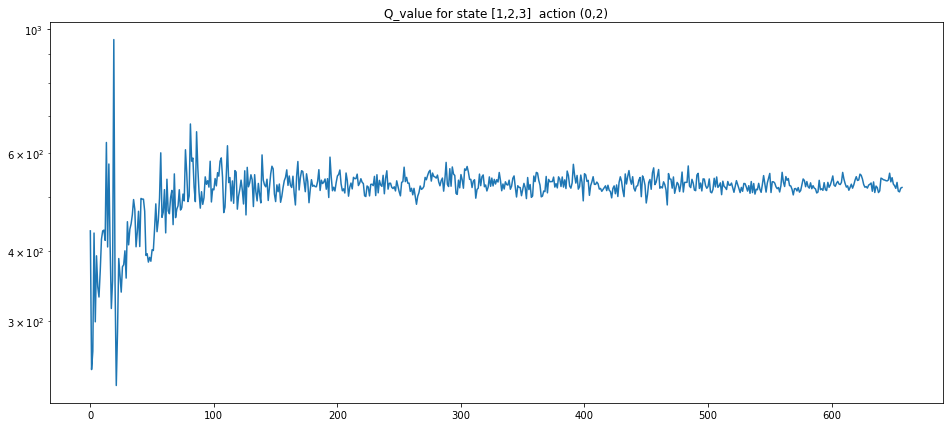

In [11]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,2,3]  action (0,2)')
xaxis = np.asarray(range(0, len(state_tracked_sample)))
## We are using log scale because the initial q_values are way to high compared to the steady state value
plt.semilogy(xaxis,np.asarray(state_tracked_sample))
plt.show()

#### Track rewards per episode.

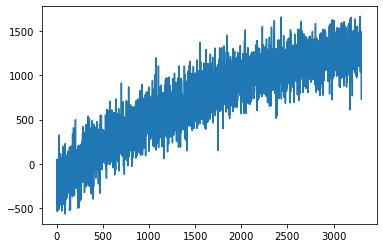

In [12]:
plt.plot(episodes,rewards_per_episode)
#The below graph shows that the rewards increased and got stabilised after 6000 epochs as given by the epsilon function at the end of file

In [13]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

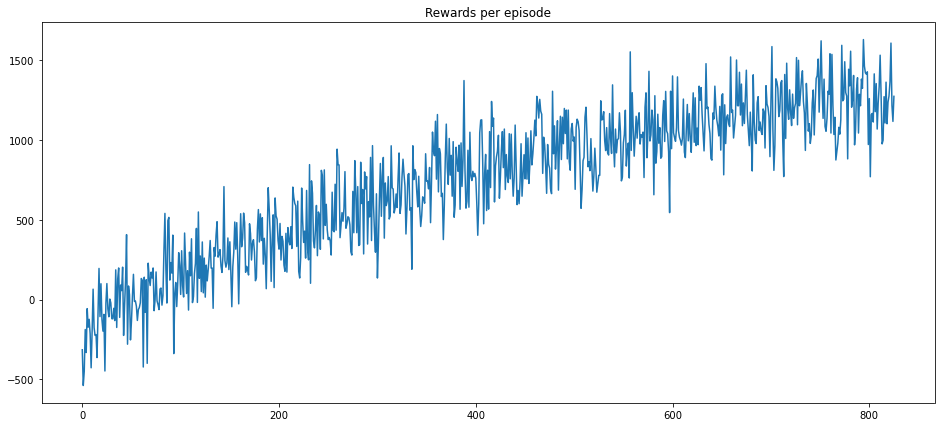

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

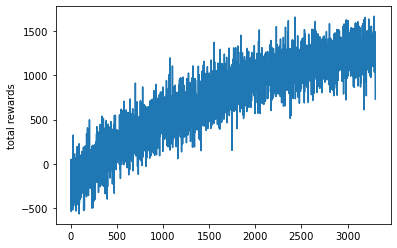

In [15]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [16]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-177.36, -72.97, -25.8, 94.54, 174.4, 229.14, 297.65, 342.04, 393.51, 494.23, 527.01, 576.58, 614.28, 659.06, 729.78, 790.65, 833.93, 881.3, 924.48, 966.81, 960.65, 1016.69, 1056.42, 1037.52, 1092.07, 1133.09, 1178.39, 1144.45, 1195.54, 1206.7, 1227.94, 1269.23, 1287.0, 1003.0]


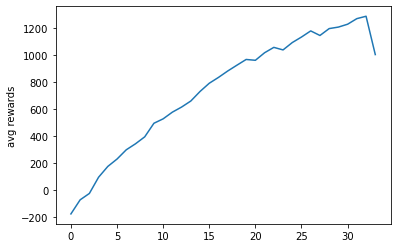

In [17]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

#### Epsilon-decay sample function

#Try building a similar epsilon-decay function for your model.

In [28]:
import numpy as np
time = np.arange(0,3302)
epsilon = []
for i in range(0,3302):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

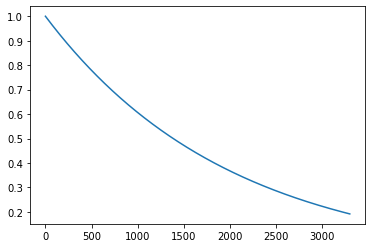

In [29]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()

#### ploting the epsilon value used for all the episodes

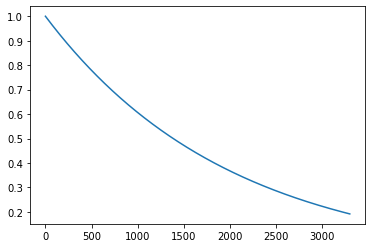

In [30]:
## track_epsilon stores epsilon values
plt.plot(time, track_epsilon)
plt.show()